In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
import skimage.io
import os 
import tqdm
import glob
import tensorflow 
import cv2
import pywt

from tqdm import tqdm
from sklearn.utils import shuffle
from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

from skimage.io import imread, imshow
from skimage.transform import resize
from skimage.color import grey2rgb

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, BatchNormalization, Dropout, Flatten, Dense, Activation, MaxPool2D, Conv2D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.utils import to_categorical
from keras import optimizers

from keras.callbacks import Callback,ModelCheckpoint
from keras.models import Sequential,load_model
from keras.layers import Dense, Dropout
from keras.wrappers.scikit_learn import KerasClassifier
import keras.backend as K

from typeguard import typechecked
from typing import Optional

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#Unziping the dataset

!unzip -q "/content/drive/MyDrive/Garvin/IEEE/Alzheimer's Disease Classification/Dataset.zip"

In [ ]:
def wavelet_transform(image):
    image = cv2.resize(image,(image.shape[0]*2,image.shape[1]*2))
    coeff_f = []
    for i in range(image.shape[-1]):
        c1,(c2,c3,c4) = pywt.dwt2(image[:,:,i], wavelet = 'db3', mode = 'periodization')
        coeff_f.append(c1)
        coeff_f.append(c2)
        coeff_f.append(c3)
        # coeff_f.append(c4)
        return np.moveaxis(np.array(coeff_f),0,-1)

train_datagen = ImageDataGenerator( rescale = 1./255,
                                    validation_split = 0.2,                        
                                    rotation_range=5,
                                    width_shift_range=0.2,
                                    height_shift_range=0.2,
                                    shear_range=0.2,
                                    #zoom_range=0.2,
                                    horizontal_flip=True,
                                    vertical_flip=True,
                                    fill_mode='nearest',
                                    preprocessing_function = wavelet_transform)

valid_datagen = ImageDataGenerator(rescale = 1./255,
                                  validation_split = 0.2,
                                  preprocessing_function = wavelet_transform)

test_datagen  = ImageDataGenerator(rescale = 1./255,
                                   preprocessing_function = wavelet_transform)

In [ ]:
train_dataset  = train_datagen.flow_from_directory(directory = '/content/Alzheimer_s Dataset/train',
                                                   target_size = (224,224),
                                                   class_mode = 'categorical',
                                                   subset = 'training',
                                                   batch_size = 32)

valid_dataset = valid_datagen.flow_from_directory(directory = '/content/Alzheimer_s Dataset/train',
                                                  target_size = (224,224),
                                                  class_mode = 'categorical',
                                                  subset = 'validation',
                                                  batch_size = 32)

test_dataset = test_datagen.flow_from_directory(directory = '/content/Alzheimer_s Dataset/test',
                                                  target_size = (224,224),
                                                  class_mode = 'categorical',
                                                  batch_size = 32)

Found 4098 images belonging to 4 classes.
Found 1023 images belonging to 4 classes.
Found 1279 images belonging to 4 classes.


In [ ]:
base_model = tf.keras.applications.MobileNet(input_shape=(224,224,3), 
                   include_top=False,
                   weights="imagenet")

In [ ]:
# Freezing Layers

for layer in base_model.layers:
    layer.trainable=False

In [ ]:
# Building Model

model=Sequential()
model.add(base_model)
model.add(Dropout(0.5))
model.add(Flatten())
model.add(BatchNormalization())
model.add(Dense(32,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(32,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(32,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dense(4,activation='softmax'))

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenet_1.00_224 (Function (None, 7, 7, 1024)        3228864   
_________________________________________________________________
dropout (Dropout)            (None, 7, 7, 1024)        0         
_________________________________________________________________
flatten (Flatten)            (None, 50176)             0         
_________________________________________________________________
batch_normalization (BatchNo (None, 50176)             200704    
_________________________________________________________________
dense (Dense)                (None, 32)                1605664   
_________________________________________________________________
batch_normalization_1 (Batch (None, 32)                128       
_________________________________________________________________
activation (Activation)      (None, 32)                0

In [ ]:
def f1_score(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val 

In [ ]:
METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),  
      tf.keras.metrics.AUC(name='auc'),
       f1_score,
]

In [ ]:
def exponential_decay(lr0, s):
    def exponential_decay_fn(epoch):
        return lr0 * 0.1 **(epoch / s)
    return exponential_decay_fn

exponential_decay_fn = exponential_decay(0.01, 5) # when i run it for 50 epochs

lr_scheduler = tf.keras.callbacks.LearningRateScheduler(exponential_decay_fn)

In [ ]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy',metrics=METRICS)

In [ ]:
# history=model.fit(train_dataset,
#                   validation_data=valid_dataset,
#                   epochs = 100,
#                   verbose = 1,
#                   callbacks=lr_scheduler) 

NameError: ignored

In [ ]:
# model.save_weights("/content/drive/MyDrive/Garvin/IEEE/Alzheimer's Disease Classification/model_mobile.hdf5")

In [ ]:
weights_file=os.path.join("/content/drive/MyDrive/Garvin/IEEE/Alzheimer's Disease Classification/model_mobile_wavelet.hdf5")
 
checkpoint = ModelCheckpoint(weights_file, monitor='val_accuracy', verbose=1, 
                             save_best_only=True, mode='max', save_weights_only = False)

callbacks= [checkpoint, lr_scheduler]

In [ ]:
history=model.fit(train_dataset,
                  validation_data=valid_dataset,
                  epochs = 100,
                  verbose = 1,
                  callbacks=callbacks)

Epoch 1/100
129/129 [==============================] - 79s 614ms/step - loss: 0.9893 - accuracy: 0.7818 - precision: 0.6379 - recall: 0.2940 - auc: 0.8118 - f1_score: 0.4004 - val_loss: 1.0327 - val_accuracy: 0.7879 - val_precision: 0.6396 - val_recall: 0.3470 - val_auc: 0.8167 - val_f1_score: 0.4468

Epoch 00001: val_accuracy improved from -inf to 0.78788, saving model to /content/drive/MyDrive/Garvin/IEEE/Alzheimer's Disease Classification/model_mobile_wavelet.hdf5
Epoch 2/100
129/129 [==============================] - 80s 617ms/step - loss: 0.9563 - accuracy: 0.7900 - precision: 0.6775 - recall: 0.3050 - auc: 0.8239 - f1_score: 0.4194 - val_loss: 0.9897 - val_accuracy: 0.7881 - val_precision: 0.7484 - val_recall: 0.2297 - val_auc: 0.7938 - val_f1_score: 0.3461

Epoch 00002: val_accuracy improved from 0.78788 to 0.78812, saving model to /content/drive/MyDrive/Garvin/IEEE/Alzheimer's Disease Classification/model_mobile_wavelet.hdf5
Epoch 3/100
129/129 [==============================] 

In [ ]:
model.save('/content/drive/MyDrive/Garvin/IEEE/saved_model')

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Garvin/IEEE/saved_model/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Garvin/IEEE/saved_model/assets


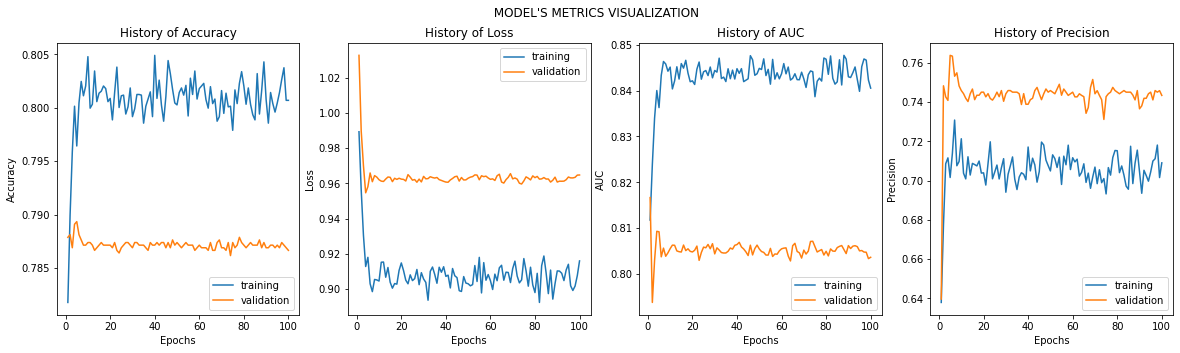

In [ ]:
def Train_Val_Plot(acc,val_acc,loss,val_loss,auc,val_auc,precision,val_precision):
    
    fig, (ax1, ax2,ax3,ax4) = plt.subplots(1,4, figsize= (20,5))
    fig.suptitle(" MODEL'S METRICS VISUALIZATION ")

    ax1.plot(range(1, len(acc) + 1), acc)
    ax1.plot(range(1, len(val_acc) + 1), val_acc)
    ax1.set_title('History of Accuracy')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Accuracy')
    ax1.legend(['training', 'validation'])


    ax2.plot(range(1, len(loss) + 1), loss)
    ax2.plot(range(1, len(val_loss) + 1), val_loss)
    ax2.set_title('History of Loss')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Loss')
    ax2.legend(['training', 'validation'])
    
    ax3.plot(range(1, len(auc) + 1), auc)
    ax3.plot(range(1, len(val_auc) + 1), val_auc)
    ax3.set_title('History of AUC')
    ax3.set_xlabel('Epochs')
    ax3.set_ylabel('AUC')
    ax3.legend(['training', 'validation'])
    
    ax4.plot(range(1, len(precision) + 1), precision)
    ax4.plot(range(1, len(val_precision) + 1), val_precision)
    ax4.set_title('History of Precision')
    ax4.set_xlabel('Epochs')
    ax4.set_ylabel('Precision')
    ax4.legend(['training', 'validation'])
    
  
    plt.show()
    

Train_Val_Plot(history.history['accuracy'],history.history['val_accuracy'],
               history.history['loss'],history.history['val_loss'],
               history.history['auc'],history.history['val_auc'],
               history.history['precision'],history.history['val_precision']
              )

In [ ]:
scores = model.evaluate(test_dataset)

40/40 [==============================] - 10s 238ms/step - loss: 0.9138 - accuracy: 0.7969 - precision: 0.6695 - recall: 0.3706 - auc: 0.8400 - f1_score: 0.4738


In [ ]:
print("Accuracy = ", scores[1])
print("Precision = ", scores[2])
print("Recall = ", scores[3])
print("AUC = ", scores[4])
print("F1 = ", scores[5])

Accuracy =  0.7969116568565369
Precision =  0.6694915294647217
Recall =  0.3706020414829254
AUC =  0.8399645686149597
F1 =  0.47383180260658264
